[<img src="https://gitlab.irit.fr/toc/etu-n7/controle-optimal/-/raw/master/ressources/Logo-toulouse-inp-N7.png" alt="N7" height="100"/>](https://gitlab.irit.fr/toc/etu-n7/controle-optimal)

# Méthode directe et indirecte

- Date : 2025
- Durée approximative : 1.5 séance

Le but est de résoudre par une méthode de tir, un problème de contrôle optimal dont le contrôle est discontinu. On se propose de résoudre dans un premier temps, le problème par une méthode directe, afin de déterminer la structure optimale et une bonne approximation de la solution pour faire converger la méthode de tir.

In [7]:
using Pkg
Pkg.add("Ipopt")

using JuMP, Ipopt # pour la méthode directe
using DifferentialEquations, NLsolve, ForwardDiff # pour la méthode indirecte
using Plots # pour les graphiques
include("utils.jl"); # fonctions utilitaires

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


<div style="width:95%;
            margin:10px;
            padding:8px;
            color:white;
            background-color: rgb(46, 109, 4);
            border-radius:10px;
            font-weight:bold;
            font-size:1.5em;
            text-align:center;">
Introduction
</div>

On considère le problème de contrôle optimal suivant :

$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle \min_{x, u} \displaystyle \int_0^{t_f} x^2(t) \, \mathrm{d}t \\[1.0em]
        \dot{x}(t) = \displaystyle u(t), \quad  |u(t)| \le 1, \quad t \in [0, t_f] \text{ p.p.},    \\[1.0em]
        x(0) = 1, \quad x(t_f) = 1/2
    \end{array}
    \right. 
$$
où $t_f$ = 2.

✏️ **Exercice 1.**

1. Calculer le contrôle maximisant donné par le principe du maximum de Pontryagin (on pourra l'écrire comme une [fonction multivaluée](https://fr.wikipedia.org/wiki/Fonction_multivaluée)) .
2. Peut-on appliquer simplement la méthode de tir simple vu au TP précédent ?

1°) On suppose $p^{0} = -1$ 
 
$H = pu + p^{0}x^{2} = pu -x^{2}$

$$
\left\{ 
    \begin{array}{l}
        \dot{x} = u \\
        \dot{p} = -\frac{\partial H}{\partial x} = 2x
    \end{array}
    \right. 
$$

$ max_{|u| < 1} pu - x^{2}$

$$
u(p) = 
\left\{ 
    \begin{array}{l}
        = 1 \text{ si p > 0} \\
        = -1 \text{ si p < 0} \\
        = [-1,1] \text{ sinon}

    \end{array}
    \right. 
$$

<div style="width:95%;
            margin:10px;
            padding:8px;
            color:white;
            background-color: rgb(46, 109, 4);
            border-radius:10px;
            font-weight:bold;
            font-size:1.5em;
            text-align:center;">
Méthode directe
</div>

Avant de définir la méthode directe, on propose une réécriture du problème. Ce n'est pas une obligation mais cela simplifie l'écriture.

✏️ **Exercice 2.** 

- Mettre le problème sous forme de Mayer (cf. cours). Vous nommerez la nouvelle variable d'état associée au coût $c(\cdot)$.

$$\textbf{Solution}$$

$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle \min c(2) = c(0) + \displaystyle \int_0^{2} x^2(t) \, \mathrm{d}t \\[1.0em]
        \dot{x}(t) = \displaystyle u(t), \quad  |u(t)| \le 1, \quad t \in [0, t_f] \text{ p.p.},    \\[1.0em]
        x(0) = 1, \quad x(t_f) = 1/2
    \end{array}
    \right. 
$$



**Description de la méthode directe.**

L'idée principale est de transformer le problème de contrôle optimal (de dimension infinie) en un problème d'optimisation de dimension finie. 

Pour cela :

1. On définit une grille uniforme en temps $(t_1, \dots,  t_{N+1})$ où $t_1 = 0$ et $t_{N+1} = t_f$ avec $\Delta t = (t_f - t_0)/N$ le pas de discrétisation.
2. On discrétise l'état, le contrôle et le coût sur cette grille et on note 
$$
\{ (x_i, u_i, c_i) ~|~ i \in \{1, \dots, N+1\}\}
$$ 
l'ensemble des variables d'optimisation du problème discrétisé.

Si l'on note $(x^*(\cdot), u^*(\cdot), c^*(\cdot))$ la solution du problème de contrôle optimal et $\{ (x^*_i, u^*_i, c^*_i) ~|~ i \in \{1, \dots, N+1\}\}$ la solution du problème discrétisé, on s'attend à avoir
$$
x^*_i \approx x^*(t_i), \quad u^*_i \approx u^*(t_i), \quad c^*_i \approx c^*(t_i), \quad \forall i \in \{1, \dots, N+1\}.
$$

✏️ ️**Exercice 3.** Définir pour le problème discrétisé : 

1. L'objectif à minimiser.
2. Les contraintes d'inégalités associées au contrôle.
3. Les contraintes initiales et finales associées à la variable d'état et la contrainte de condition initiale pour le coût.
4. Les contraintes de dynamique sur l'état et le coût, en utilisant le schéma d'intégration de Crank-Nicolson (ou [règle des Trapèzes](https://fr.wikipedia.org/wiki/M%C3%A9thode_des_trap%C3%A8zes)).


✏️ ️**Exercice 4.** 

- Modifier le code suivant afin de résoudre le problème par la méthode directe que vous venez de décrire.

**Remarque.**  Vous pouvez vous inspirer de cet [exemple](https://ct.gitlabpages.inria.fr/gallery/goddard-j/goddard.html) pour le code. Notez que dans cet exemple, la fonction `@NLexpressions` est utilisée mais n'est pas nécessaire ici donc vous pouvez ou non l'utiliser.

In [28]:
# Création du modèle JuMP, Utilisation de Ipopt comme solver
sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 5))
set_optimizer_attribute(sys,"tol",1e-8)
set_optimizer_attribute(sys,"constr_viol_tol",1e-8)
set_optimizer_attribute(sys,"max_iter",1000)

#######
####### DEBUT A MODIFIER
#######
####### Les ... sont à remplacer !
#######
####### Attention, on écrit le problème sous la forme d'un problème de Mayer
#######

# Paramètres
t0 = 0    # temps initial
tf = 2    # temps final
c0 = 0    # coût initial
x0 = 1    # état initial
xf = 0.5    # état final 

N  = 5000    # taille de la grille
Δt = (tf-t0)/N  # pas de temps

@variables(sys, begin
    c[1:N+1]       # coût
    x[1:N+1]       # état
    -1.0 <= u[1:N+1] <= 1.0      # control
end)

# Objectif
@objective(sys, Min, c[N+1])

# Conditions initiales et finales
@constraints(sys, begin
    con_c0, c[1] == c0 # contraint sur le coût initial
    con_x0, x[1] == x0 # contraint sur l'état initial
    con_xf, x[N+1] == xf # contraint sur l'état final
end)

# Contraintes de dynamique avec le schéma de Crank-Nicolson
@NLconstraints(sys, begin
    con_dc[j=1:N], c[j+1] == c[j] + Δt * (x[j+1]^2 + x[j]^2)/2 # contraint différentielle sur le coût
    con_dx[j=1:N], x[j+1] == x[j] + Δt * (u[j+1] + u[j])/2 # contraint différentielle sur l'état
end);

#######
####### FIN A MODIFIER
#######

(NonlinearConstraintRef{ScalarShape}[(c[2] - (c[1] + (0.0004 * (x[2] ^ 2.0 + x[1] ^ 2.0)) / 2.0)) - 0.0 = 0, (c[3] - (c[2] + (0.0004 * (x[3] ^ 2.0 + x[2] ^ 2.0)) / 2.0)) - 0.0 = 0, (c[4] - (c[3] + (0.0004 * (x[4] ^ 2.0 + x[3] ^ 2.0)) / 2.0)) - 0.0 = 0, (c[5] - (c[4] + (0.0004 * (x[5] ^ 2.0 + x[4] ^ 2.0)) / 2.0)) - 0.0 = 0, (c[6] - (c[5] + (0.0004 * (x[6] ^ 2.0 + x[5] ^ 2.0)) / 2.0)) - 0.0 = 0, (c[7] - (c[6] + (0.0004 * (x[7] ^ 2.0 + x[6] ^ 2.0)) / 2.0)) - 0.0 = 0, (c[8] - (c[7] + (0.0004 * (x[8] ^ 2.0 + x[7] ^ 2.0)) / 2.0)) - 0.0 = 0, (c[9] - (c[8] + (0.0004 * (x[9] ^ 2.0 + x[8] ^ 2.0)) / 2.0)) - 0.0 = 0, (c[10] - (c[9] + (0.0004 * (x[10] ^ 2.0 + x[9] ^ 2.0)) / 2.0)) - 0.0 = 0, (c[11] - (c[10] + (0.0004 * (x[11] ^ 2.0 + x[10] ^ 2.0)) / 2.0)) - 0.0 = 0  …  (c[4992] - (c[4991] + (0.0004 * (x[4992] ^ 2.0 + x[4991] ^ 2.0)) / 2.0)) - 0.0 = 0, (c[4993] - (c[4992] + (0.0004 * (x[4993] ^ 2.0 + x[4992] ^ 2.0)) / 2.0)) - 0.0 = 0, (c[4994] - (c[4993] + (0.0004 * (x[4994] ^ 2.0 + x[4993] ^ 2.0)) /

In [29]:
# Solve for the control and state
println("Solving...")
optimize!(sys)
println()

# Display results
if termination_status(sys) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(sys))
println()

# Retrieves values (including duals)
c  = value.(c)[:]
x  = value.(x)[:]
u  = value.(u)[:]
t  = (0:N) * value.(Δt)

pc0 = dual(con_c0)
px0 = dual(con_x0)
pxf = dual(con_xf)

if(pc0*dual(con_dc[1])<0); pc0 = -pc0; end
if(px0*dual(con_dx[1])<0); px0 = -px0; end
if(pxf*dual(con_dx[N])<0); pxf = -pxf; end

if (pc0 > 0) # Sign convention according to Pontryagin Maximum Principle
    sign = -1.0
else
    sign =  1.0
end

pc = [ dual(con_dc[i]) for i in 1:N ]
px = [ dual(con_dx[i]) for i in 1:N ]

pc = sign * [pc0; pc[1:N]] 
px = sign * [px0; (px[1:N-1]+px[2:N])/2; pxf]; # We add the multiplier from the limit conditions

Solving...
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:    40003
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    10000

Total number of variables............................:    15003
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     5001
                     variables with only upper bounds:        0
Total number of equality constraints.................:    10003
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+0

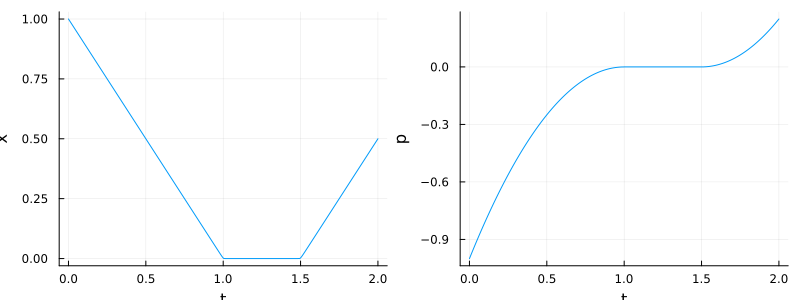

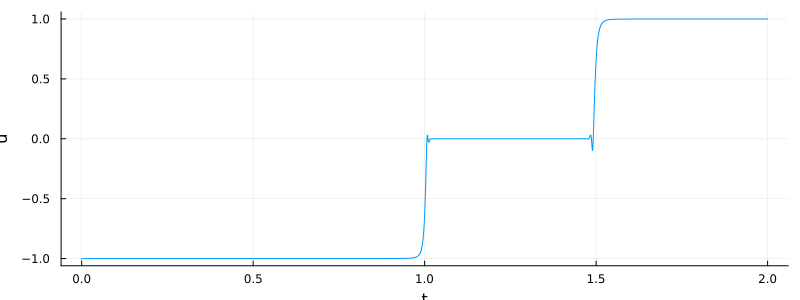

In [30]:
x_plot = plot(t, x, xlabel = "t", ylabel = "x", legend = false)
u_plot = plot(t, u, xlabel = "t", ylabel = "u", legend = false, size=(800,300), linetype=:steppre)
px_plot = plot(t, px, xlabel = "t", ylabel = "p", legend = false)
display(plot(x_plot, px_plot, layout = (1,2), size=(800,300)))
display(u_plot)

✏️ ️**Exercice 5.** 

1. Commenter les résultats. 
2. Modifier la tolérance de l'optimiseur ainsi que le nombre de points de discrétisation. Commentaires.
3. Décrire la structure du contrôle optimal en fonction du temps.

<div style="width:95%;
            margin:10px;
            padding:8px;
            color:white;
            background-color: rgb(46, 109, 4);
            border-radius:10px;
            font-weight:bold;
            font-size:1.5em;
            text-align:center;">
Méthode de tir indirect
</div>

D'après la condition de maximisation du hamiltonien et la structure optimale de la solution, nous avons besoin de définir 3 fonctions permettant de calculer les flots des systèmes hamiltoniens associés aux contrôles +1, -1 et au contrôle dit **singulier** qui apparaît lorsque la **fonction de commutation** reste nulle sur un intervalle de temps non réduit à un singleton. La fonction de commutation est la fonction qui détermine la valeur du contrôle en fonction du signe de celle-ci.

✏️ ️️**Exercice 6.** 

1. Donner la fonction de commutation.
2. En dérivant deux fois par rapport au temps la fonction de commutation, trouver une condition vérifiée par l'état et une condition vérifiée par le contrôle le long d'un arc singulier, c'est-à-dire le long d'un arc où la fonction de commutation est constante égale à 0.
3. Remplir le code ci-dessous: il faut fournir les 3 contrôles pour définir les flots, puis écrire la fonction de tir.

**Remarque.** La fonction de tir à 3 variables inconnues. Il faut donc trouver 3 équations. La condition terminale en est une. L'annulation de la fonction de commutation au premier temps de commutation en est une autre. La question 2 aide à trouver la dernière condition.


In [34]:
# système pseudo-hamiltonien
function hv(x, p, u)
    return [u, 2x]
end

# systèmes hamiltoniens
hv_min(x, p) = hv(x, p, -1) ## REMPLACER NaN par la bonne valeur
hv_max(x, p) = hv(x, p, 1) ## REMPLACER NaN par la bonne valeur
hv_sin(x, p) = hv(x, p, 0) ## REMPLACER NaN par la bonne valeur

# flots
fmin = Flow(hv_min)
fmax = Flow(hv_max)
fsin = Flow(hv_sin)

# fonction de tir
function shoot(p0, t1, t2)
    
    # integration
    x1, p1 = fmin(t0, x0, p0, t1) # x1, p1 sont des scalaires
    x2, p2 = fsin(t1, x1, p1, t2)
    x3, p3 = fmax(t2, x2, p2, tf)
    
    # conditions
    s = zeros(eltype(p0), 3)
    s[1] = -1  ## REMPLACER NaN par la bonne expression
    s[2] = 0  ## REMPLACER NaN par la bonne expression
    s[3] = 1  ## REMPLACER NaN par la bonne expression
    
    return s

end;

4. Trouver (remplir le code ci-dessous) à partir de la solution de la méthode directe, une bonne initialisation pour la fonction de tir.

In [36]:
# itéré initiale pour la méthode indirecte de tir
p0 = -1 ## REMPLACER NaN par une bonne valeur
t1 = 1 ## REMPLACER NaN par une bonne valeur
t2 = 1.5 ## REMPLACER NaN par une bonne valeur

#
y = [ p0 ; t1 ; t2]

println("Itéré initial:\n", y)

Itéré initial:
[-1.0, 1.0, 1.5]


In [ ]:
# fonction de tir et sa jacobienne
foo(y) = shoot(y...)
jfoo(y) = ForwardDiff.jacobian(foo, y)

# Résolution de shoot(p0, t1, t2) = 0.
nl_sol = nlsolve(foo, jfoo, y; xtol=1e-8, method=:trust_region, show_trace=true);

# Retrieves solution
if converged(nl_sol)
    p0 = nl_sol.zero[1]
    t1 = nl_sol.zero[2]
    t2 = nl_sol.zero[3];
    println("\nFinal solution:\n", nl_sol.zero)
else
    error("Not converged")
end

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.000000e+00              NaN
     1     1.000000e+00     0.000000e+00
     2     1.000000e+00     0.000000e+00
     3     1.000000e+00     0.000000e+00
     4     1.000000e+00     0.000000e+00
     5     1.000000e+00     0.000000e+00
     6     1.000000e+00     0.000000e+00
     7     1.000000e+00     0.000000e+00
     8     1.000000e+00     0.000000e+00
     9     1.000000e+00     0.000000e+00
    10     1.000000e+00     0.000000e+00
    11     1.000000e+00     0.000000e+00
    12     1.000000e+00     0.000000e+00
    13     1.000000e+00     0.000000e+00
    14     1.000000e+00     0.000000e+00
    15     1.000000e+00     0.000000e+00
    16     1.000000e+00     0.000000e+00
    17     1.000000e+00     0.000000e+00
    18     1.000000e+00     0.000000e+00
    19     1.000000e+00     0.000000e+00
    20     1.000000e+00     0.000000e+00
    21     1.000000e+00     0.000000e+00
    22     1.00000

ErrorException: Not converged

In [ ]:
# affichage de la solution
ode_sol = fmin((t0, t1), x0, p0)
tt0 = ode_sol.t
xx0 = [ ode_sol[1, j] for j in 1:size(tt0, 1) ]
pp0 = [ ode_sol[2, j] for j in 1:size(tt0, 1) ]
uu0 = -ones(size(tt0, 1))

ode_sol = fsin((t1, t2), xx0[end], pp0[end])
tt1 = ode_sol.t
xx1 = [ ode_sol[1, j] for j in 1:size(tt1, 1) ]
pp1 = [ ode_sol[2, j] for j in 1:size(tt1, 1) ]
uu1 = zeros(size(tt1, 1))

ode_sol = fmax((t2, tf), xx1[end], pp1[end])
tt2 = ode_sol.t
xx2 = [ ode_sol[1, j] for j in 1:size(tt2, 1) ]
pp2 = [ ode_sol[2, j] for j in 1:size(tt2, 1) ]
uu2 = ones(size(tt2, 1))

t_shoot = [ tt0 ; tt1 ; tt2 ]
x_shoot = [ xx0 ; xx1 ; xx2 ]
p_shoot = [ pp0 ; pp1 ; pp2 ]
u_shoot = [ uu0 ; uu1 ; uu2 ]    

x_plot = plot(t_shoot, x_shoot, xlabel = "t", ylabel = "x", legend = false)
u_plot = plot(t_shoot, u_shoot, xlabel = "t", ylabel = "u", legend = false, size=(800,300), linetype=:steppre)
px_plot = plot(t_shoot, p_shoot, xlabel = "t", ylabel = "px", legend = false)
display(plot(x_plot, px_plot, layout = (1,2), size=(800, 300)))
display(u_plot)

5. Comparer avec l'affichage de la solution de la méthode directe.